# Libraries

In [3]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import *
from pgmpy.inference import VariableElimination
from pgmpy.metrics import *
from pgmpy.metrics.bn_inference import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv(f'data{os.sep}heart.csv')

In [5]:
df = df[~(df['Cholesterol'] == 0) & ~(df['RestingBP'] == 0)]

In [6]:
df['ExerciseAngina'] = df['ExerciseAngina'].apply(lambda x: False if x == 'N' else True)
df['HeartDisease'] = df['HeartDisease'].apply(lambda x: False if x == 0 else True)
df['FastingBS'] = df['FastingBS'].apply(lambda x: False if x == 0 else True)

In [7]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,False,Normal,172,False,0.0,Up,False
1,49,F,NAP,160,180,False,Normal,156,False,1.0,Flat,True
2,37,M,ATA,130,283,False,ST,98,False,0.0,Up,False
3,48,F,ASY,138,214,False,Normal,108,True,1.5,Flat,True
4,54,M,NAP,150,195,False,Normal,122,False,0.0,Up,False


In [8]:
df.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,133.022788,244.635389,140.226542,0.901609
std,9.505888,17.282750,59.153524,24.524107,1.072861
min,28.000000,92.000000,85.000000,69.000000,-0.100000
25%,46.000000,120.000000,207.250000,122.000000,0.000000
50%,54.000000,130.000000,237.000000,140.000000,0.500000
75%,59.000000,140.000000,275.000000,160.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


# Preprocessing

In [9]:
df['Oldpeak'].describe()

count    746.000000
mean       0.901609
std        1.072861
min       -0.100000
25%        0.000000
50%        0.500000
75%        1.500000
max        6.200000
Name: Oldpeak, dtype: float64

In [10]:
df[['Oldpeak', 'ST_Slope']].groupby('ST_Slope').describe()

Oldpeak                                             
           count      mean       std  min  25%  50%  75%  max
ST_Slope                                                     
Down        43.0  2.593023  1.333880  0.0  1.5  2.5  3.5  6.2
Flat       354.0  1.319774  0.979885  0.0  0.5  1.2  2.0  5.0
Up         349.0  0.269054  0.585470 -0.1  0.0  0.0  0.2  4.0

In [36]:
pd.qcut(x=df["Oldpeak"], q=3)

0      (-0.101, 0.0]
1         (0.0, 1.2]
2      (-0.101, 0.0]
3         (1.2, 6.2]
4      (-0.101, 0.0]
           ...      
913       (0.0, 1.2]
914       (1.2, 6.2]
915       (0.0, 1.2]
916    (-0.101, 0.0]
917    (-0.101, 0.0]
Name: Oldpeak, Length: 746, dtype: category
Categories (3, interval[float64, right]): [(-0.101, 0.0] < (0.0, 1.2] < (1.2, 6.2]]

In [21]:
df["Age"] = pd.qcut(x=df["Age"], q=2)
df["RestingBP"] = pd.cut(x=df["RestingBP"], bins=[90, 120, 140, 1000], labels=["normal", "high", "very high"])
df["Cholesterol"] = pd.cut(x=df["Cholesterol"], bins=[0, 200, 240, 1000], labels=["optimal", "borderline", "high"])
df["MaxHR"] = pd.cut(x=df["MaxHR"], bins=3)
df["Oldpeak"] = pd.cut(x=df["Oldpeak"], bins=[], labels=["low", "medium", "high"])

In [22]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,"(27.999, 54.0]",M,ATA,140,high,False,Normal,high,False,low,Up,False
1,"(27.999, 54.0]",F,NAP,160,optimal,False,Normal,high,False,medium,Flat,True
2,"(27.999, 54.0]",M,ATA,130,high,False,ST,low,False,low,Up,False
3,"(27.999, 54.0]",F,ASY,138,borderline,False,Normal,low,True,high,Flat,True
4,"(27.999, 54.0]",M,NAP,150,optimal,False,Normal,low,False,low,Up,False


<Axes: xlabel='Age,Cholesterol'>

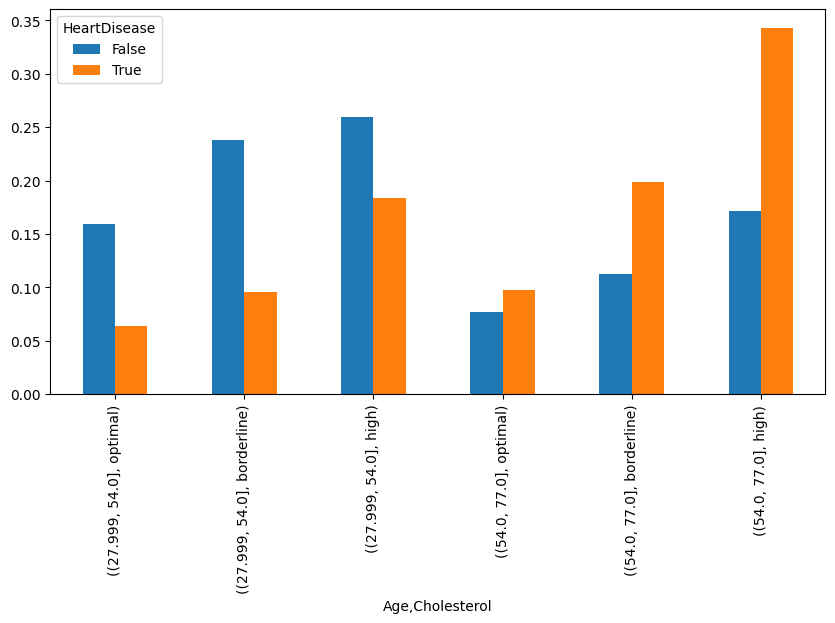

In [23]:
df[['Cholesterol', 'HeartDisease', 'Age']].groupby(
    'Age').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False, figsize=(10, 5))

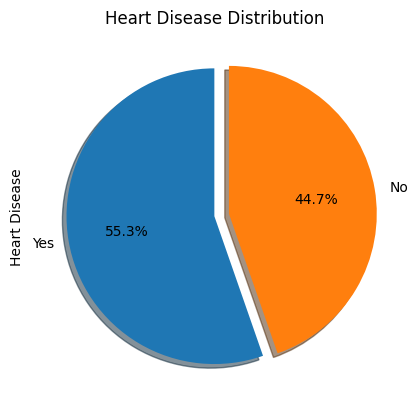

In [7]:
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, explode=[0, 0.1], shadow=True, labels=["Yes", "No"], label="Heart Disease", title="Heart Disease Distribution")
plt.show()

In [8]:
target_variable = "HeartDisease"

In [9]:
X, y = df.drop(columns=target_variable), df[target_variable]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
train = pd.concat([X_train, y_train], axis=1)

# Naive Bayes

In [12]:
nb_model = BayesianNetwork([(target_variable, y) for y in X.columns])

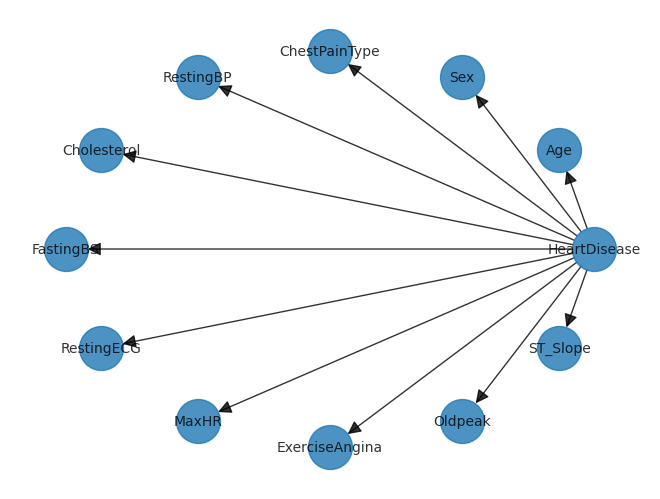

In [13]:
nx.draw_circular(nb_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [15]:
nb_model.fit(train)
nb_cpds = nb_model.get_cpds()
assert nb_model.check_model()

In [78]:
y_pred = nb_model.predict(X_test)
y_pred.head()

100%|██████████| 180/180 [00:00<00:00, 1096.35it/s]


,HeartDisease
0,0
1,0
2,1
3,1
4,0


In [79]:
accuracy_score(y_test, y_pred[target_variable])

0.8315217391304348

In [80]:
precision_score(y_test, y_pred[target_variable])

0.9042553191489362

In [81]:
recall_score(y_test, y_pred[target_variable])

0.794392523364486

In [82]:
f1_score(y_test, y_pred[target_variable])

0.845771144278607

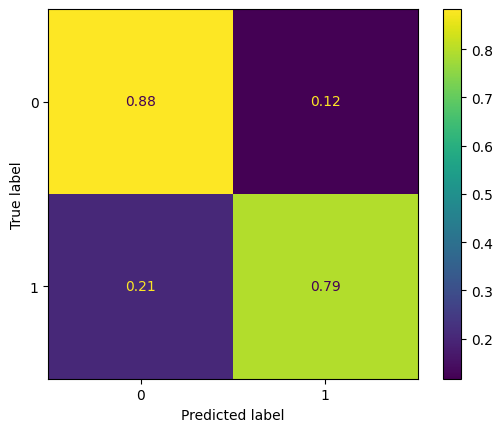

In [85]:
cm = confusion_matrix(y_test, y_pred[target_variable], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [86]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.8387547032406846

In [87]:
roc_curve(y_true=y_test, y_score=y_pred)

(array([0.        , 0.11688312, 1.        ]),
 array([0.        , 0.79439252, 1.        ]),
 array([inf,  1.,  0.]))

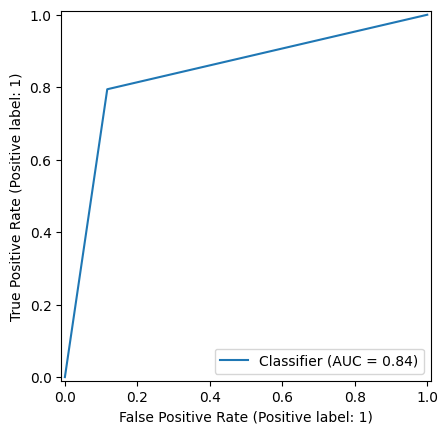

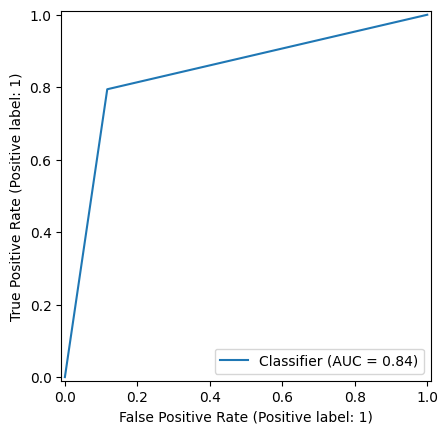

In [88]:
RocCurveDisplay.from_predictions(y_test, y_pred).plot()
plt.show()

# Hill Climbing

In [149]:
hc = HillClimbSearch(df).estimate(
    scoring_method='aicscore', black_list=[(x, target_variable) for x in X_train.columns])

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 28/1000000 [00:02<24:55:03, 11.15it/s]


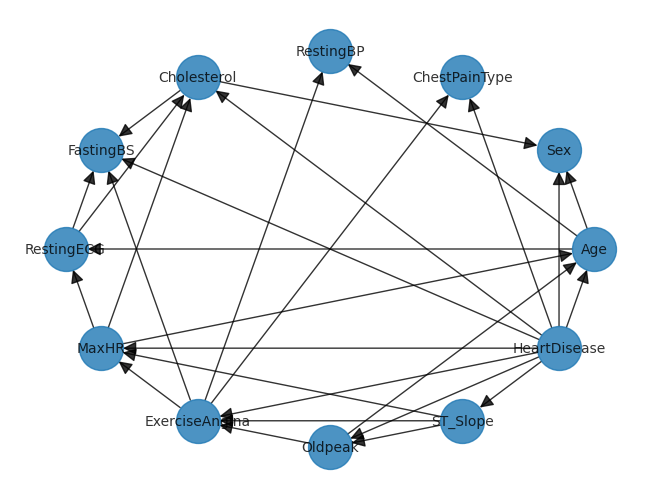

In [150]:
nx.draw_circular(hc, with_labels=True, arrowsize=20,
                 node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [151]:
hc_model = BayesianNetwork(hc.edges())

hc_model.fit(train, estimator=BayesianEstimator)
hc_cpds = hc_model.get_cpds()
assert hc_model.check_model()

/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and w

In [152]:
y_pred = hc_model.predict(X_test)
y_pred.head()

100%|██████████| 180/180 [00:00<00:00, 798.77it/s]


,HeartDisease
0,0
1,1
2,1
3,1
4,0


In [153]:
accuracy_score(y_test, y_pred[target_variable])

0.875

In [154]:
precision_score(y_test, y_pred[target_variable])

0.92

In [155]:
recall_score(y_test, y_pred[target_variable])

0.8598130841121495

In [156]:
f1_score(y_test, y_pred[target_variable])

0.8888888888888888

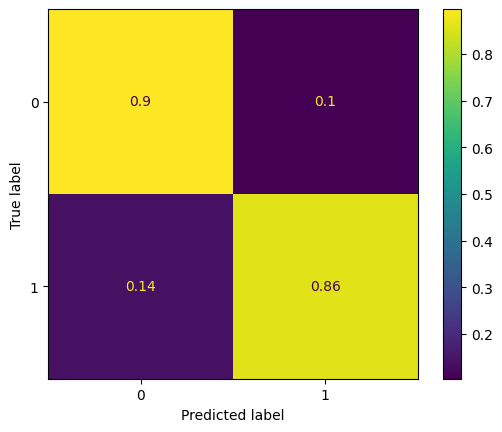

In [157]:
cm = confusion_matrix(y_test, y_pred[target_variable], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [158]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.8779584901080228

In [159]:
roc_curve(y_true=y_test, y_score=y_pred)

(array([0.       , 0.1038961, 1.       ]),
 array([0.        , 0.85981308, 1.        ]),
 array([inf,  1.,  0.]))

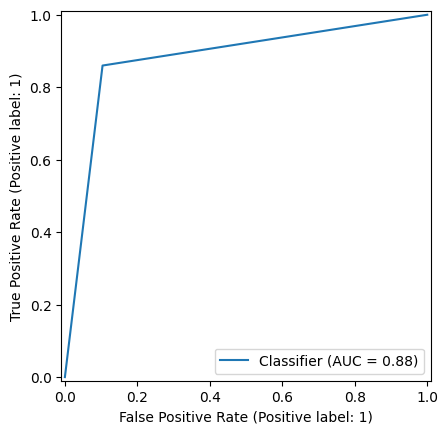

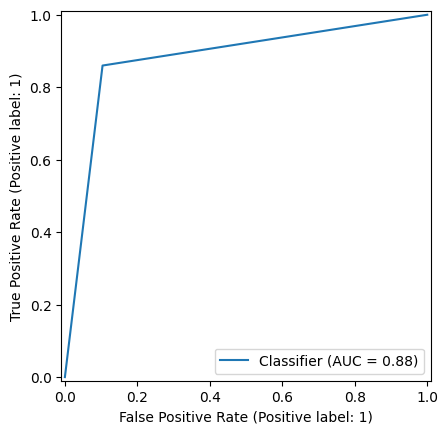

In [160]:
RocCurveDisplay.from_predictions(y_test, y_pred).plot()
plt.show()

# Tree Search

In [161]:
est = TreeSearch(df, root_node=target_variable)

In [162]:
tree_model = est.estimate(estimator_type="chow-liu")

Building tree: 100%|██████████| 66/66.0 [00:00<00:00, 1372.02it/s]


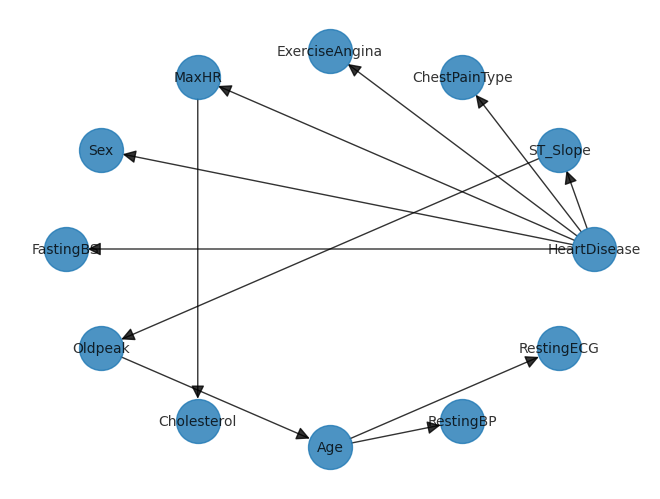

In [163]:
nx.draw_circular(tree_model, with_labels=True, arrowsize=20,
                 node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [164]:
tree_model = BayesianNetwork(tree_model.edges())

tree_model.fit(train, estimator=BayesianEstimator)
tree_cpds = tree_model.get_cpds()
assert tree_model.check_model()

/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and w

In [165]:
y_pred = tree_model.predict(X_test)
y_pred.head()

100%|██████████| 180/180 [00:00<00:00, 876.07it/s]


,HeartDisease
0,0
1,0
2,1
3,1
4,0


In [166]:
accuracy_score(y_test, y_pred[target_variable])

0.8206521739130435

In [167]:
precision_score(y_test, y_pred[target_variable])

0.8936170212765957

In [168]:
recall_score(y_test, y_pred[target_variable])

0.7850467289719626

In [169]:
f1_score(y_test, y_pred[target_variable])

0.835820895522388

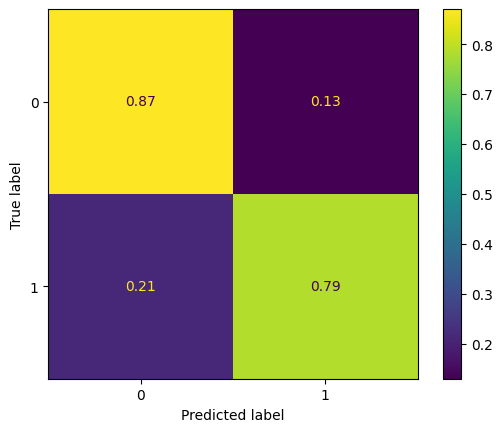

In [170]:
cm = confusion_matrix(y_test, y_pred[target_variable], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [171]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.8275882995509163

In [172]:
roc_curve(y_true=y_test, y_score=y_pred)

(array([0.        , 0.12987013, 1.        ]),
 array([0.        , 0.78504673, 1.        ]),
 array([inf,  1.,  0.]))

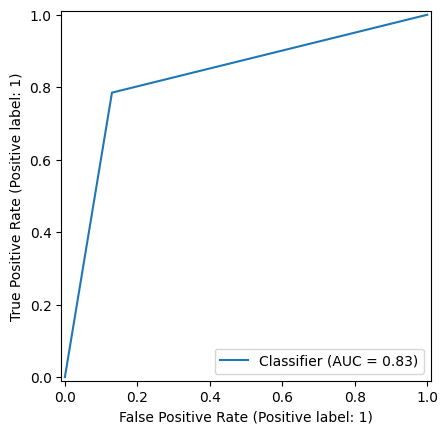

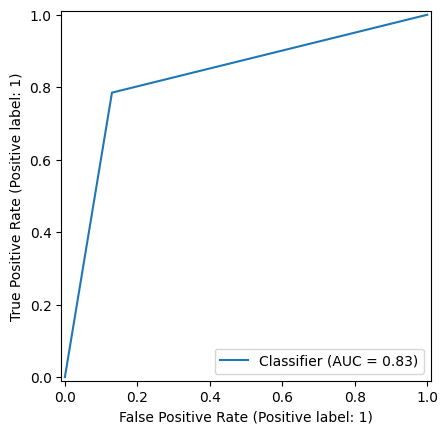

In [173]:
RocCurveDisplay.from_predictions(y_test, y_pred).plot()
plt.show()

# TAN

In [176]:
est = TreeSearch(df, root_node=target_variable)
tan_model = est.estimate(estimator_type="tan", class_node='Age')

Building tree: 100%|██████████| 66/66.0 [00:00<00:00, 1080.45it/s]


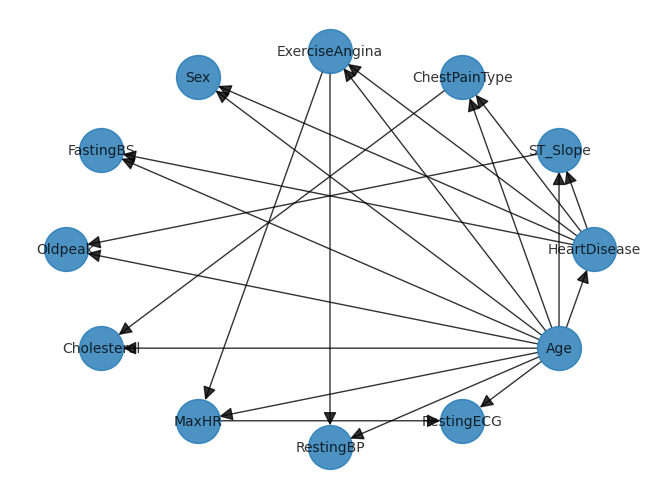

In [177]:
nx.draw_circular(tan_model, with_labels=True, arrowsize=20,
                 node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [178]:
tan_model = BayesianNetwork(tan_model.edges())

tan_model.fit(train, estimator=BayesianEstimator)
tan_cpds = tan_model.get_cpds()
assert tan_model.check_model()

/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and w

In [179]:
y_pred = tan_model.predict(X_test)
y_pred.head()

100%|██████████| 180/180 [00:00<00:00, 792.95it/s]


,HeartDisease
0,0
1,1
2,1
3,1
4,0


In [180]:
accuracy_score(y_test, y_pred[target_variable])

0.8532608695652174

In [181]:
precision_score(y_test, y_pred[target_variable])

0.9

In [182]:
recall_score(y_test, y_pred[target_variable])

0.8411214953271028

In [183]:
f1_score(y_test, y_pred[target_variable])

0.8695652173913043

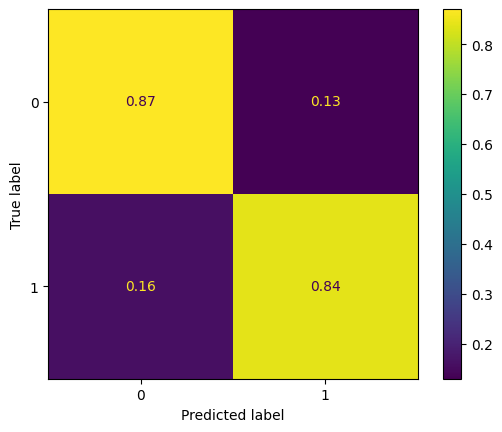

In [184]:
cm = confusion_matrix(y_test, y_pred[target_variable], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [185]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.8556256827284863

In [186]:
roc_curve(y_true=y_test, y_score=y_pred)

(array([0.        , 0.12987013, 1.        ]),
 array([0.       , 0.8411215, 1.       ]),
 array([inf,  1.,  0.]))

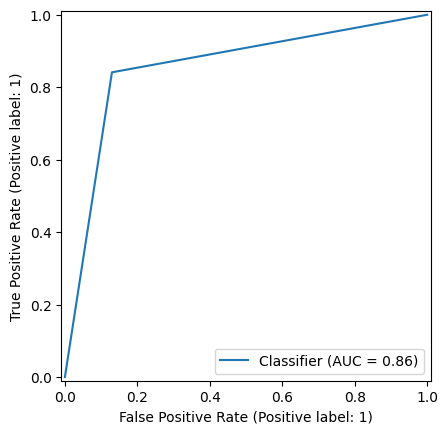

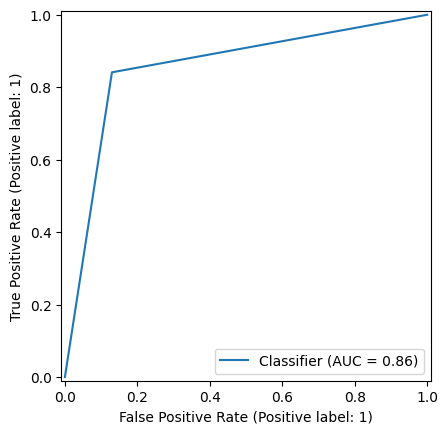

In [187]:
RocCurveDisplay.from_predictions(y_test, y_pred).plot()
plt.show()

# Test

In [114]:
test = HillClimbSearch(df).estimate(tabu_length=100000, epsilon=1e-16, black_list=[(x, target_variable) for x in X_train.columns])

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 22/1000000 [00:01<18:53:13, 14.71it/s]


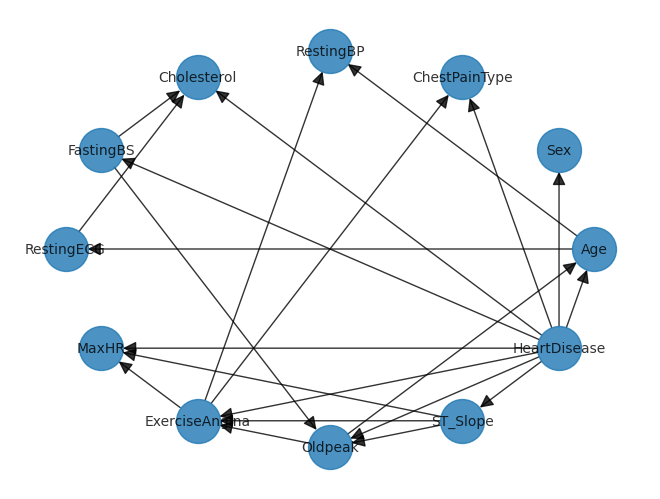

In [115]:
nx.draw_circular(test, with_labels=True, arrowsize=20,
                 node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [116]:
test = BayesianNetwork(test.edges())

test.fit(train, estimator=BayesianEstimator)
test_cpds = test.get_cpds()
assert test.check_model()

In [117]:
y_pred = test.predict(X_test)
y_pred.head()

100%|██████████| 180/180 [00:00<00:00, 709.55it/s]


,HeartDisease
0,0
1,1
2,1
3,1
4,0


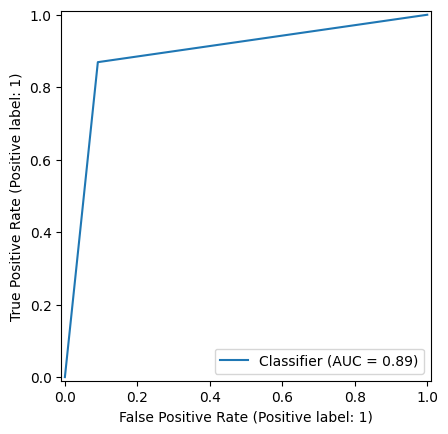

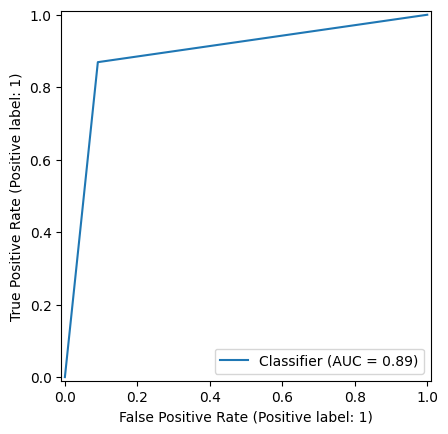

In [118]:
RocCurveDisplay.from_predictions(y_test, y_pred).plot()
plt.show()